In [16]:
import numpy as np
import torch
import torchquantum as tq
import torchquantum.functional as tqf
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from IPython.display import clear_output
from dataset import QuantumSensingDataset
from qnn import QuantumSensing, QuantumML0, QuantumML1

In [2]:
# data
root_dir = 'qml-data/toy/train'
train_dataset = QuantumSensingDataset(root_dir)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
root_dir = 'qml-data/toy/test'
test_dataset = QuantumSensingDataset(root_dir)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)
print(train_dataset.__len__())
print(test_dataset.__len__())
print(train_dataset[0])

300
100
{'phase': array([4.0597625, 3.9561498, 2.978269 , 2.9022985], dtype=float32), 'label': array(0)}


In [13]:
def compute_accuracy(output_all, target_all):
    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    return accuracy

epoch=24
train loss=0.3507965709033765
test loss=0.3527739005429404
train accuracy=1.0
test accuracy=1.0


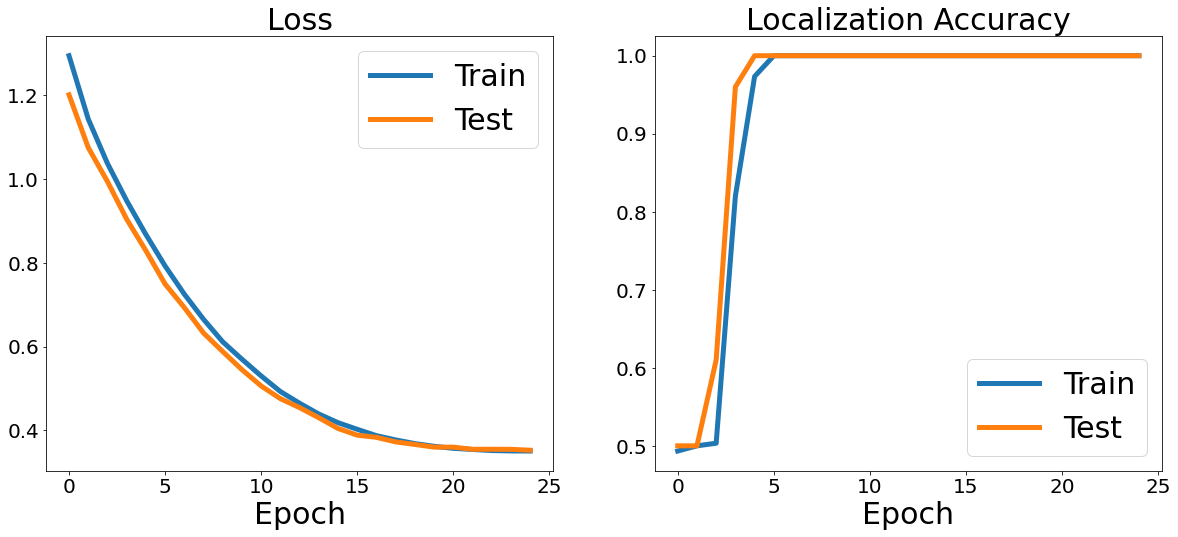

In [22]:
# the model and training related variables
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
model = QuantumML0(n_wires=4, n_locations=4).to(device)
n_epochs = 25
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for e in range(n_epochs):
    model.train()
    loss_list = []
    target_all = []
    output_all = []
    for t, sample in enumerate(train_dataloader):
        thetas = sample['phase']
        targets = sample['label'].to(device)
        # preparing sensing data
        bsz = thetas.shape[0]
        n_qubits = thetas.shape[1]
        qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
        qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
        qsensing(qstate)
        q_device = tq.QuantumDevice(n_wires=n_qubits)
        q_device.reset_states(bsz=bsz)
        # the model
        outputs = model(q_device, qstate.states)
        # compute loss, gradient, optimize, etc...
        loss = F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        target_all.append(targets)
        output_all.append(outputs)
        if t % 10 == 0:
            print(f'loss={loss.item()}')
    train_loss.append(np.mean(loss_list))
    target_all = torch.cat(target_all)
    output_all = torch.cat(output_all)
    accuracy = compute_accuracy(output_all, target_all)
    train_acc.append(accuracy)
    
    model.eval()
    loss_list = []
    target_all = []
    output_all = []
    with torch.no_grad():
        for t, sample in enumerate(test_dataloader):
            thetas = sample['phase']
            targets = sample['label'].to(device)
            bsz = thetas.shape[0]
            n_qubits = thetas.shape[1]
            qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
            qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
            qsensing(qstate)
            q_device = tq.QuantumDevice(n_wires=n_qubits)
            q_device.reset_states(bsz=bsz)
            # the model
            outputs = model(q_device, qstate.states)
            loss = F.nll_loss(outputs, targets)
            loss_list.append(loss.item())
            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all)
        output_all = torch.cat(output_all)
    test_loss.append(np.mean(loss_list))
    accuracy = compute_accuracy(output_all, target_all)
    test_acc.append(accuracy)
    scheduler.step()
    clear_output(True)
    print(f'epoch={e}')
    print(f'train loss={train_loss[-1]}')
    print(f'test loss={test_loss[-1]}')
    print(f'train accuracy={train_acc[-1]}')
    print(f'test accuracy={test_acc[-1]}')
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_loss, label='Train', linewidth=5)
    plt.plot(test_loss,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Localization Accuracy', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_acc, label='Train', linewidth=5)
    plt.plot(test_acc,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.show()

epoch=24
train loss=0.38455748558044434
test loss=0.3957845526082175
train accuracy=1.0
test accuracy=1.0


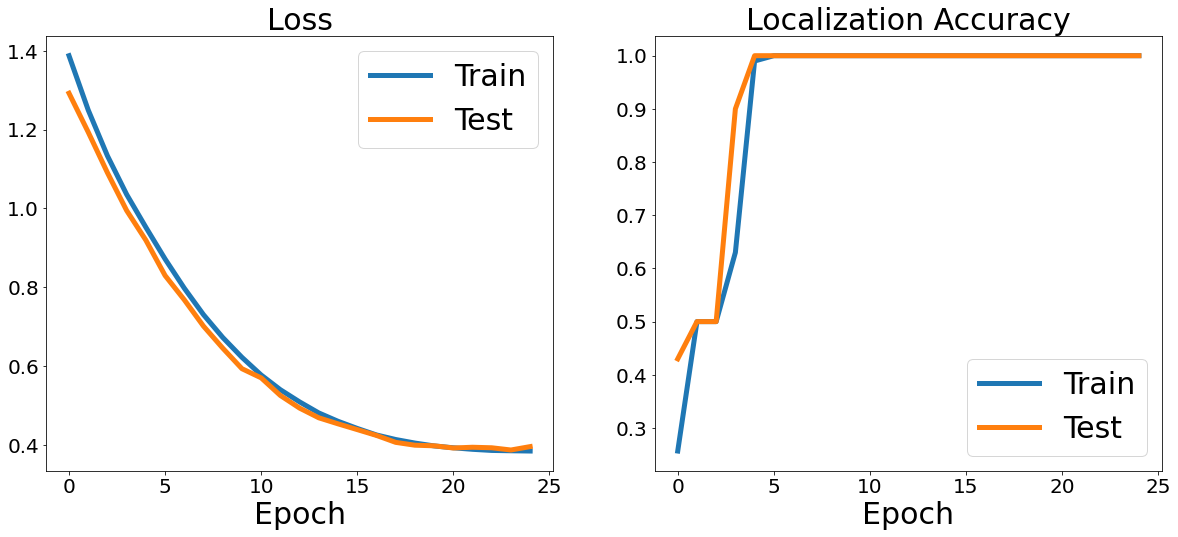

In [26]:
# the model and training related variables
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
model = QuantumML1(n_wires=4, n_locations=4).to(device)
n_epochs = 25
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for e in range(n_epochs):
    model.train()
    loss_list = []
    target_all = []
    output_all = []
    for t, sample in enumerate(train_dataloader):
        thetas = sample['phase']
        targets = sample['label'].to(device)
        # preparing sensing data
        bsz = thetas.shape[0]
        n_qubits = thetas.shape[1]
        qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
        qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
        qsensing(qstate)
        q_device = tq.QuantumDevice(n_wires=n_qubits)
        q_device.reset_states(bsz=bsz)
        # the model
        outputs = model(q_device, qstate.states)
        # compute loss, gradient, optimize, etc...
        loss = F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        target_all.append(targets)
        output_all.append(outputs)
        if t % 10 == 0:
            print(f'loss={loss.item()}')
    train_loss.append(np.mean(loss_list))
    target_all = torch.cat(target_all)
    output_all = torch.cat(output_all)
    accuracy = compute_accuracy(output_all, target_all)
    train_acc.append(accuracy)
    
    model.eval()
    loss_list = []
    target_all = []
    output_all = []
    with torch.no_grad():
        for t, sample in enumerate(test_dataloader):
            thetas = sample['phase']
            targets = sample['label'].to(device)
            bsz = thetas.shape[0]
            n_qubits = thetas.shape[1]
            qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
            qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
            qsensing(qstate)
            q_device = tq.QuantumDevice(n_wires=n_qubits)
            q_device.reset_states(bsz=bsz)
            # the model
            outputs = model(q_device, qstate.states)
            loss = F.nll_loss(outputs, targets)
            loss_list.append(loss.item())
            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all)
        output_all = torch.cat(output_all)
    test_loss.append(np.mean(loss_list))
    accuracy = compute_accuracy(output_all, target_all)
    test_acc.append(accuracy)
    scheduler.step()
    clear_output(True)
    print(f'epoch={e}')
    print(f'train loss={train_loss[-1]}')
    print(f'test loss={test_loss[-1]}')
    print(f'train accuracy={train_acc[-1]}')
    print(f'test accuracy={test_acc[-1]}')
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_loss, label='Train', linewidth=5)
    plt.plot(test_loss,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Localization Accuracy', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_acc, label='Train', linewidth=5)
    plt.plot(test_acc,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.show()